# Projet de Télédétection : Cartographie des strates végétales (Pyrénées 24-25)

Matteo Lannelongue


## 1. Initialisation de l'environnement



In [22]:
# Projet de Télédétection : Cartographie des strates végétales (Pyrénées 24-25)
## 1. Initialisation de l'environnement

import sys
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from osgeo import gdal

# Imports Scikit-Learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedGroupKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# --- Configuration des chemins ---
sys.path.append('/home/onyxia/work/') 
sys.path.append('/home/onyxia/work/projet_teledec/notebook/') 

# Import des modules
from libsigma import read_and_write as rw
from libsigma import classification as cla
import my_function as mf 

# --- CHEMIN ABSOLU ---
data_dir = '/home/onyxia/work/data/projet_eval'

results_dir = "results/"
fig_dir = os.path.join(results_dir, "figure/")

# Création des dossiers de sortie
os.makedirs(fig_dir, exist_ok=True)

print(f"Environnement chargé. Dossier de données : {data_dir}")

Environnement chargé. Dossier de données : /home/onyxia/work/data/projet_eval


# 2. Analyse Initiale des Échantillons
## 2.1. Distribution du jeu de données (Polygones et Pixels)

In [23]:
import sys
import os

#DOSSIER contenant my_function.py
sys.path.append('/home/onyxia/work/projet_teledec/notebook/') 

import my_function as mf 


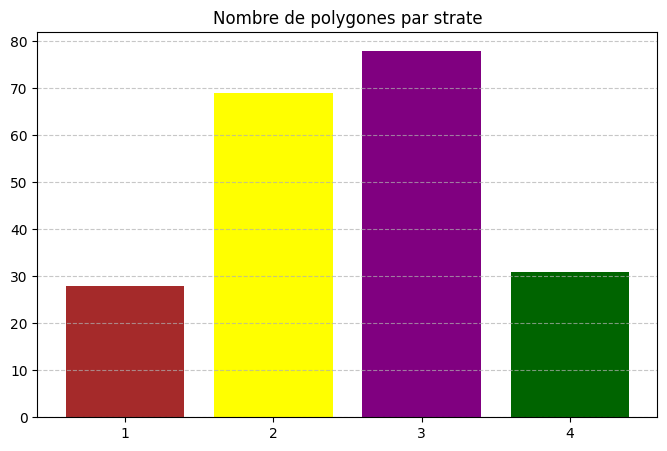

Figure sauvegardée : results/figure/diag_baton_nb_poly_by_class.png


Rasterisation OK : /home/onyxia/work/data/projet_eval/sample_strata.tif


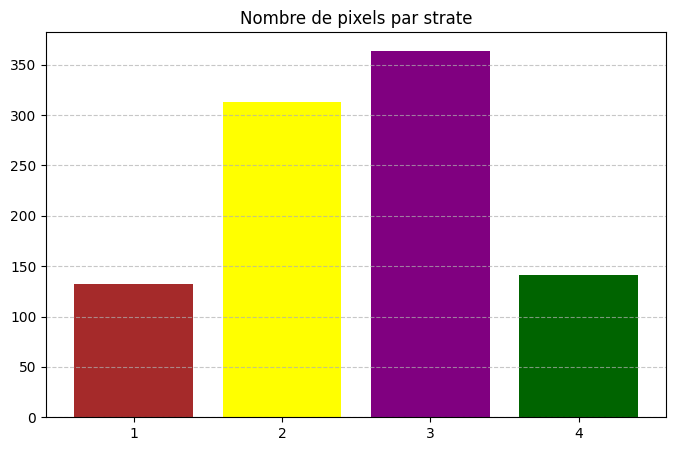

Figure sauvegardée : results/figure/diag_baton_nb_pix_by_class.png


In [24]:
import importlib
importlib.reload(mf)

# 2. Analyse Initiale des Échantillons
## 2.1. Distribution du jeu de données

# --- Analyse des Polygones ---
mf.plot_poly_counts(
    shp_path=os.path.join(data_dir, 'PI_strates_pyrenees_32630.shp'),
    col='strate',       
    out_path='results/figure/diag_baton_nb_poly_by_class.png' 
)

# --- Rasterisation ---
mf.rasterize_shapefile(
    ref_path=os.path.join(data_dir, 'pyrenees_24-25_B02.tif'),
    shp_path=os.path.join(data_dir, 'PI_strates_pyrenees_32630.shp'),
    out_path=os.path.join(data_dir, 'sample_strata.tif'),      
    col='strate'
)

# --- Analyse des Pixels ---
mf.plot_pixel_counts(
    img_path=os.path.join(data_dir, 'sample_strata.tif'), 
    out_path='results/figure/diag_baton_nb_pix_by_class.png'
)



## 1. Analyse de l'échantillonnage 
    
Cette étape sert à évaluer la qualité de la base d'apprentissage avant de lancer l'algorithme de classification. Nous analysons ici la représentativité des quatre classes : 1 (Sol Nu), 2 (Herbe), 3 (Landes) et 4 (Arbres).

### 1.1. Distribution par polygones
L'analyse du nombre de polygones par strate montre un déséquilibre dans la collecte des données de terrain :
Dominante : La classe 3 (Landes) est la mieux représentée avec près de 80 polygones.
Minoritaire : Les classes 1 (Sol Nu) et 4 (Arbres) disposent de moins de 35 polygones chacune.
Intermédiaire : La classe 2 (Herbe) présente un bon échantillonnage avec environ 70 polygones.

### 1.2. Distribution par pixels
Après rasterisation, la distribution des pixels confirme la tendance observée au niveau des polygones :
Les Landes (3) et l'Herbe (2) ont le plus grand volume de pixels (entre 300 et 350 pixels par classe).
Le Sol Nu (1) et les Arbres (4) restent sous-représentés avec moins de 150 pixels chacun.

### 1.3. Synthèse et impact sur le modèle
Le déséquilibre observé est un point de vigilance pour la suite du projet :
Risque de biais : L'algorithme Random Forest pourrait avoir une tendance naturelle à surestimer les classes majoritaires (Landes/Herbe) au détriment des classes minoritaires (Arbres/Sol Nu).
Indépendance : Pour limiter ce biais, j'ai choisi d'utiliser StratifiedGroupKFold lors de l'optimisation. Elle permettra de s'assurer que les pixels d'un même polygone entre l'entraînement et le test ne se mélangent pas.

# 3. Caractérisation des Landes (Analyse Phénologique)
## 3.1. Calcul de l'indice NARI (Normalized Anthocyanin Reflectance Index)

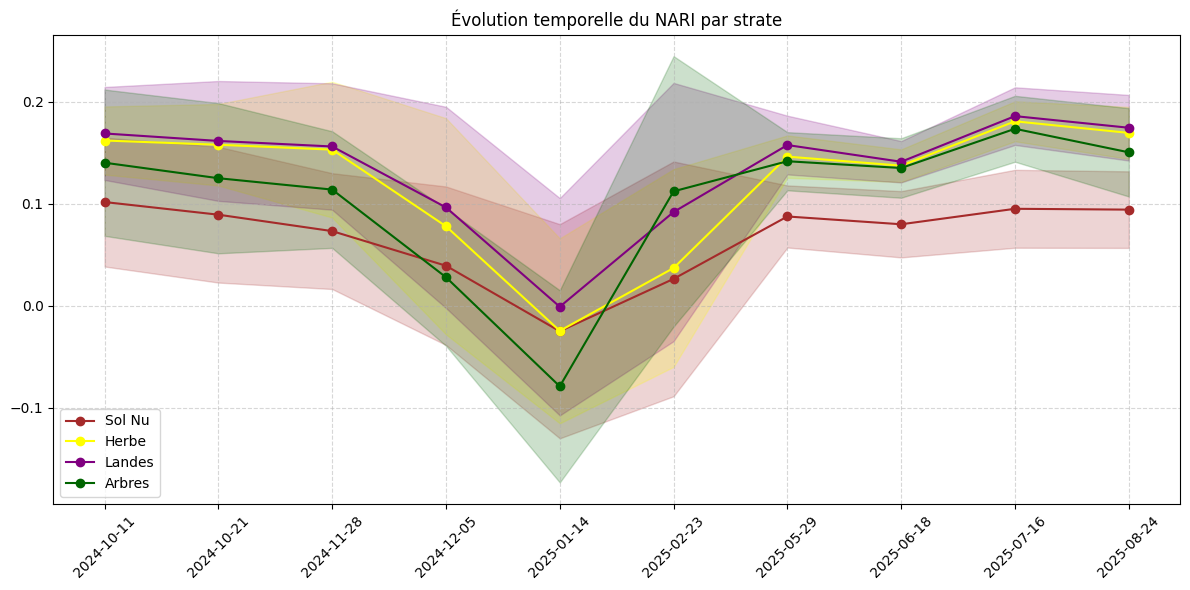

In [25]:
import my_function as mf
import importlib
import os
importlib.reload(mf)

# Paramètres
dates_list = ['2024-10-11', '2024-10-21', '2024-11-28', '2024-12-05', '2025-01-14',
              '2025-02-23', '2025-05-29', '2025-06-18', '2025-07-16', '2025-08-24']
data_folder = '/home/onyxia/work/data/projet_eval'

# Chemins de sortie (adaptés pour Git)
fig_save_path = 'results/figure/ARI_series.png'
mask_path = os.path.join(data_folder, 'sample_strata.tif') # <--- On définit le chemin du masque

# Appel corrigé (4 arguments maintenant)
mf.process_nari_phenology(
    base=data_folder, 
    dates=dates_list, 
    mask_path=mask_path, # <--- Argument ajouté ici
    out_fig=fig_save_path
)

## 2. Analyse de l'évolution temporelle 
La série temporelle (octobre 2024 à aout 2025) montre des dynamiques phénologiques distinctes pour chaque classe : 

En octobre : Les classes sont relativement distinctes, on observe bien les differences entre sol nu et Arbres et Landes/herbes. 
En novembre : Les classes Landes et herbes se chevauchent, ils sont très similaires, il est difficile de les differentier 
En janvier : Les classes deviennent difficiles a distinguer, c'est peut être du à la presence de neige, et donc l'abscence de végetation
En été, de mai à aout : Seule la classe sol est considérablement distincte des autres classes, les classes herbes landes et Arbres ont des valeurs de NARI très similaire (végétation dense)

Le NARI, servant à detecter les anthocyanes permet bien d'isoler les Landes du sol nu mais ne permet pas de séparer efficacement les 4 classes. 
    

In [26]:
import my_function as mf

results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

# Paramètres
base_data = '/home/onyxia/work/data/projet_eval'
nari_output = os.path.join(results_dir, 'ARI_serie_temp.tif')

# Exécution
mf.create_nari_raster(base_data, nari_output)

NARI créé : results/ARI_serie_temp.tif


In [27]:
import os
import my_function as mf
import importlib
importlib.reload(mf)

# --- 1. On définit les chemins et les bandes (Nécessaire pour créer X et Y) ---
data_dir = '/home/onyxia/work/data/projet_eval'
image_ref = os.path.join(data_dir, 'pyrenees_24-25_B02.tif')
shp_path = os.path.join(data_dir, 'PI_strates_pyrenees_32630.shp')
out_samples = os.path.join(data_dir, 'sample_strata.tif')
nari_path = 'results/ARI_serie_temp.tif'

bands = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']

print("Récupération des données (X, Y)...")

# --- 2. On CRÉE X et Y (C'est l'étape qui manquait) ---
X, Y, groups = mf.prepare_classification_data(
    base=data_dir, 
    ref=image_ref, 
    shp=shp_path, 
    spl_rst=out_samples, 
    bands=bands, 
    extra=[nari_path]
)

# --- 3. Maintenant, on peut lancer le graphique ---
print("Lancement du graphique 3D...")
mf.plot_seasonal_3d_ari(
    X=X, 
    Y=Y, 
    out_dir='results/figure' 
)

Récupération des données (X, Y)...
Rasterisation OK : /home/onyxia/work/data/projet_eval/PI_ids_rasterized.tif


Lancement du graphique 3D...


# Justification de l'utilisation du NARI et analyse saisonnière

L'utilisation du NARI sur l'ensemble de la série temporelle est indispensable pour discriminer les strates végétales :

Séparation Arbres/Sols vs Herbes/Landes : Globalement, l'indice permet de distinguer les ligneux hauts et les surfaces minérales des strates basses (herbacées et arbustives) qui ont une dynamique de pigments plus forte.

L'Hiver (Janvier) : C'est la période la moins utile ; la végétation est en dormance, les valeurs de NARI sont faibles et les classes sont spectralement confondues.

L'Automne (Octobre) -  Les Landes s'isolent un peu mieux avec des valeurs de NARI élevées. Cette augmentation dans l'espace 3D traduit la production d'anthocyanes, permettant de séparer les Landes des Arbres.

Printemps/Été : Les classes 1 et 4 sont bien différentiées mais la forte végétation empêche la bonne distinction entre les classes 2/3 et 3/4.

Conclusion : L'impact saisonnier justifie l'emploi du NARI comme variable clé pour garantir la précision de la classification finale. Elle permet entre autre une bonne distinction entre la classe 1 et 4.

# 4. Production de la Carte par Machine Learning


## Diagramme de flux

Le diagramme de flux ci dessous décrit les étapes principales de ce projet.

La méthodologie de cartographie des strates végétales est divisée en quatre étapes clés :

1. Données Sources (Bloc 1) : Le projet utilise deux entrées majeures situées dans le dossier data/ : le Shapefile des vérités terrain (polygones vectoriels) et les images Sentinel-2 composées de 10 dates et 10 bandes spectrales.

2. Préparation & Fichiers Intermédiaires (Bloc 2) :Le shapefile est rasterisé pour créer deux masques : un raster de Classes (labels 1, 2, 3, 4) et un raster d'IDs (identifiants uniques par polygone pour la gestion des groupes).En parallèle, l'indice phénologique NARI est calculé à partir des bandes B03 et B05 pour générer une série temporelle spécifique (ARI_serie_temp.tif).

3. Entraînement & Validation (Bloc 3) : Les pixels sont extraits pour former les matrices (variables), (labels) et Groups. Un processus d'optimisation par GridSearchCV est lancé pour trouver les meilleurs hyperparamètres du modèle Random Forest. La performance est évaluée par une validation croisée StratifiedGroupKFold (K=5), garantissant qu'un polygone entier ne peut pas être à la fois dans l'entraînement et le test.

4. Production & Analyse (Bloc 4) : Le modèle final est utilisé pour produire deux types de sorties dans le dossier results/ :Analyses graphiques : Courbes ARI, importance des variables et matrices de confusion.

5. Cartographie : Application du modèle sur l'ensemble des images pour générer la carte finale (carte_strates.tif) au format uint8 avec une valeur de NoData à 0.


![Diagramme de flux](img/diagramme_de_flux.png)

## 4.1. Préparation et Optimisation (Random Forest)

In [28]:
import my_function as mf
import importlib
import os
importlib.reload(mf)

# --- CONFIGURATION DES CHEMINS ---
base_dir = '/home/onyxia/work/data/projet_eval'
image_ref = os.path.join(base_dir, 'pyrenees_24-25_B02.tif')
shp_path = os.path.join(base_dir, 'PI_strates_pyrenees_32630.shp')
out_samples = os.path.join(base_dir, 'sample_strata.tif')

# Chemin vers le NARI (Chemin relatif simple depuis le notebook)
nari_path = 'results/ARI_serie_temp.tif'

# Liste des bandes spectrales
bands = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']

print("Préparation des données...")

# --- APPEL DES FONCTIONS ---
X, Y, groups = mf.prepare_classification_data(
    base=base_dir, 
    ref=image_ref, 
    shp=shp_path, 
    spl_rst=out_samples, 
    bands=bands, 
    extra=[nari_path] # <--- C'est ici la correction (extra au lieu de extra_indices)
)

Préparation des données...
Rasterisation OK : /home/onyxia/work/data/projet_eval/PI_ids_rasterized.tif


## 4.2. Évaluation et Importance des Variables

Best: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 200}


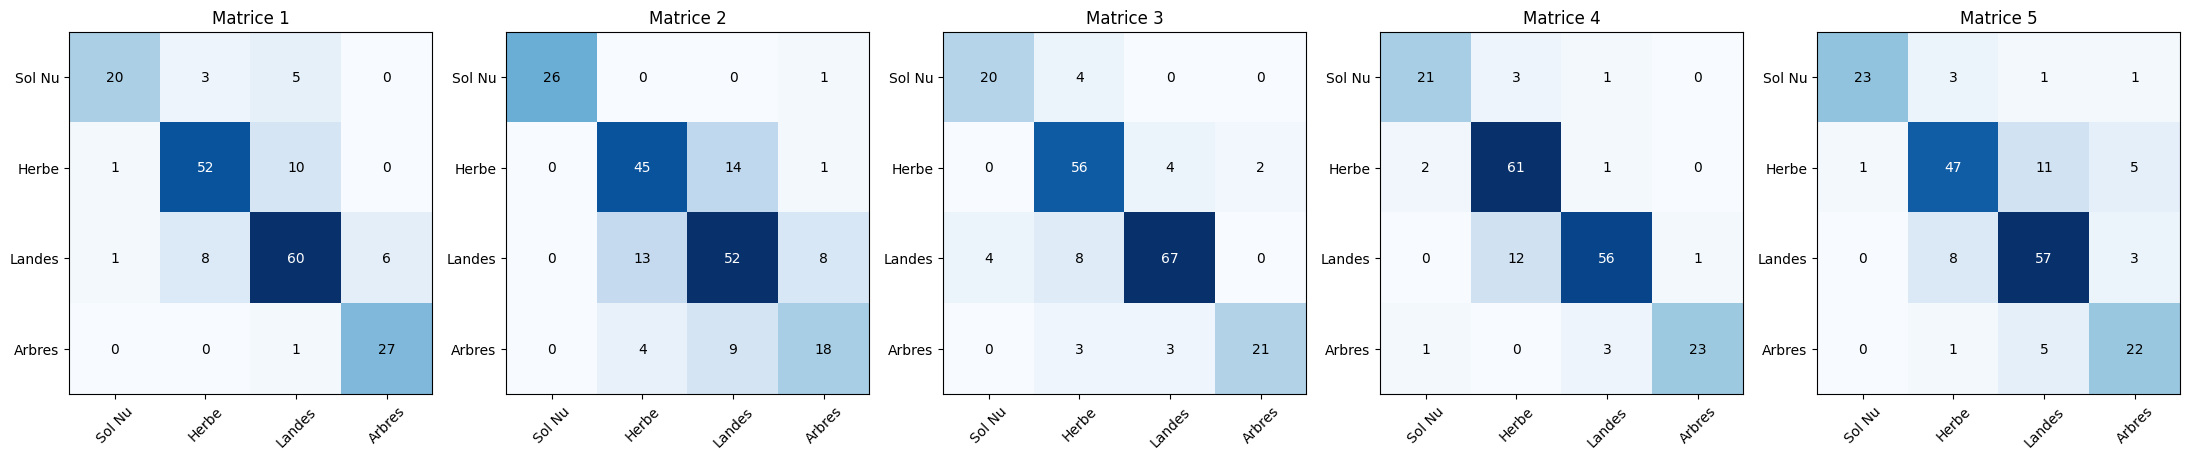

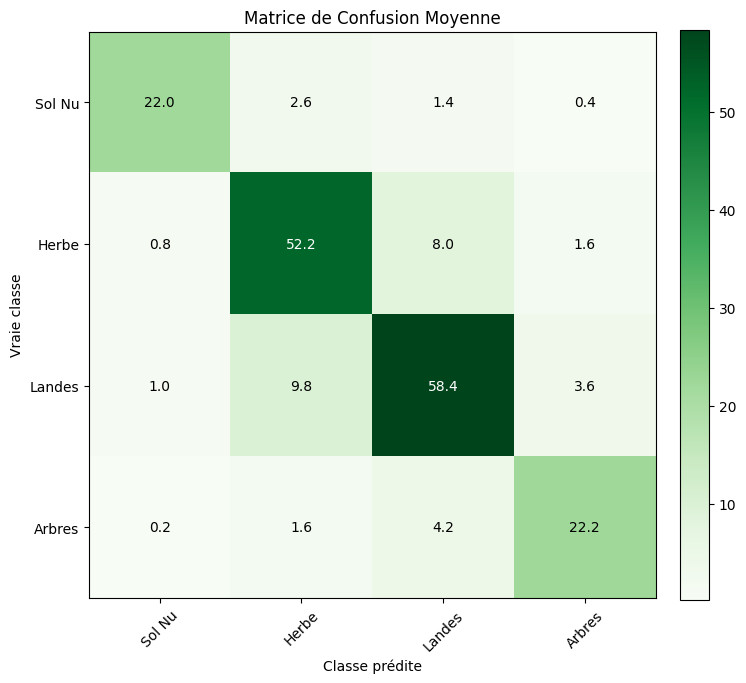

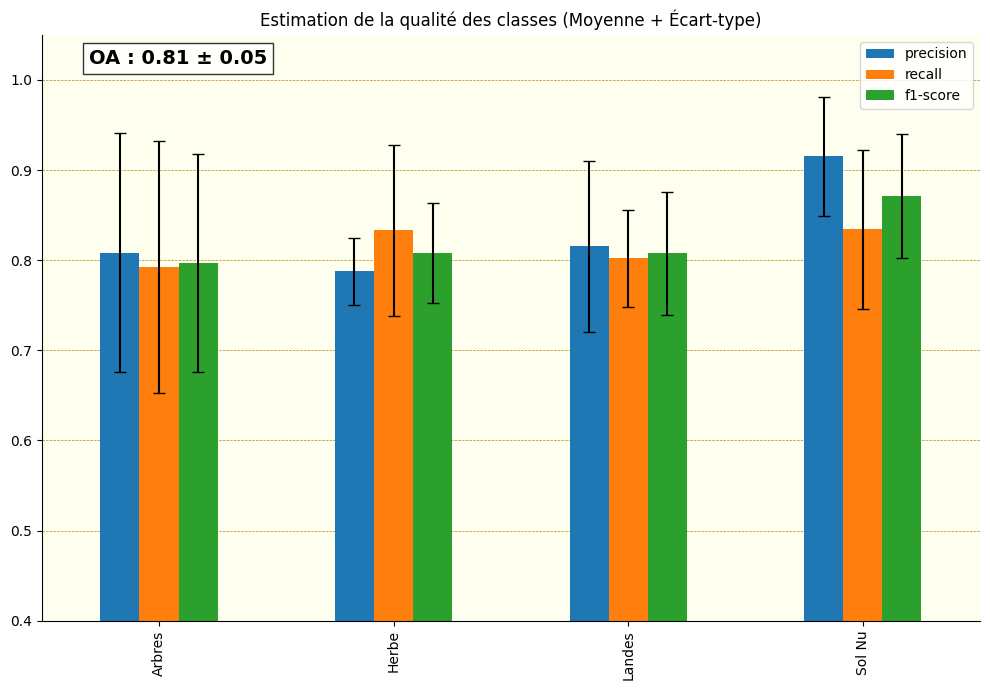

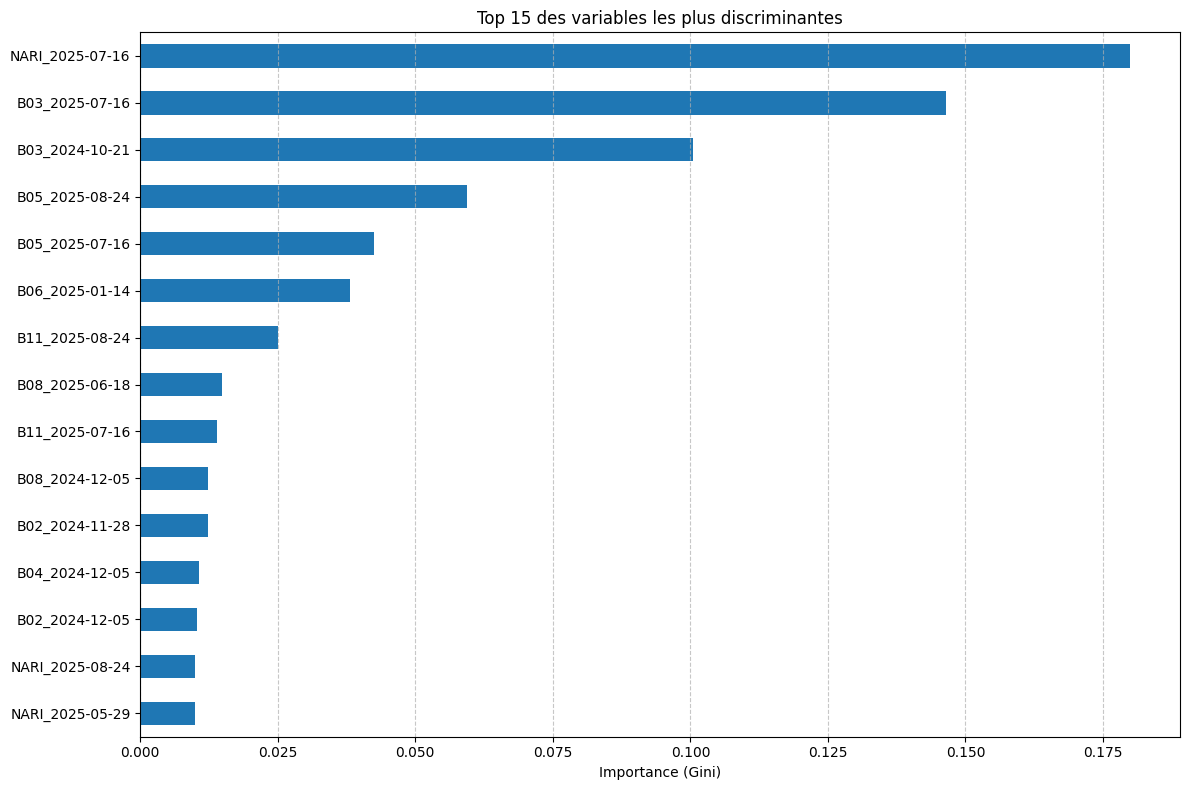

In [29]:
import my_function as mf
import importlib
importlib.reload(mf)

# --- CONFIGURATION DES PARAMÈTRES ---
target_names = ['Sol Nu', 'Herbe', 'Landes', 'Arbres']
bandes = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']
dates_reelles = ['2024-10-11', '2024-10-21', '2024-11-28', '2024-12-05', '2025-01-14',
                 '2025-02-23', '2025-05-29', '2025-06-18', '2025-07-16', '2025-08-24']

# 1. OPTIMISATION
best_clf = mf.optimize_random_forest(X, Y, groups)

# 2. ÉVALUATION (durée : env 4min45)
best_clf = mf.evaluate_model(
    model=best_clf, 
    X=X, 
    Y=Y, 
    G=groups,        # Avant: groups
    names=target_names, # Avant: target_names
    out_cm='results/figure/matrice_moyenne.png', # Avant: output_fig_path_matrix
    out_qual='results/figure/qualite_itérations.png', # Avant: output_fig_path_quality
    nb_iter=5
)

# 3. AFFICHAGE DES VARIABLES CONTRIBUTIVES
mf.plot_feature_importance(
    model=best_clf, 
    bands=bandes,   
    dates=dates_reelles, 
    out='results/figure/feature_importance_top15.png' 
)

### Justification de la Stratégie de Validation

Pour évaluer la performance de notre modèle Random Forest,j'ai utilisé la **Validation Croisée Stratifiée et Groupée** (`StratifiedGroupKFold`) avec 5 itérations ($K=5$). Ce choix répond à trois contraintes majeures de notre jeu de données :

1.  **Indépendance Spatiale (Group) :**
    Nos données proviennent de polygones rasterisés. Les pixels appartenant à un même polygone sont fortement corrélés spatialement (autocorrélation). Une séparation aléatoire simple aurait risqué de placer des pixels d'un même polygone à la fois dans le jeu d'entraînement et le jeu de test, entraînant  et une surestimation de la précision (sur-apprentissage)
    En utilisant l'identifiant du polygone comme `groupe`, on garantie qu'un polygone entier se trouve soit dans l'entraînement, soit dans le test.

2.  **Gestion du Déséquilibre (Stratified) :**
    L'analyse initiale a montré une forte disparité entre les classes majoritaires (Landes, Herbe) et minoritaires (Sol Nu, Arbres). La stratification assure que chaque tour de validation conserve les proportions exactes de chaque classe, permettant au modèle d'apprendre correctement à identifier les classes rares.

3.  **Robustesse Statistique (K-Fold) :**
    Plutôt que de se fier à une unique séparation (70/30) qui pourrait être biaisée par le hasard, la validation croisée évalue le modèle sur 5 configurations différentes de données. La moyenne des scores obtenus offre ainsi une estimation beaucoup plus fiable de la capacité de généralisation du modèle.

## Analyse de la matrice de confusion

Le modèle fonctinne globalement bien avec une précision globale de 81%

Comme attendu, les classes les mieux classés sont les arbres et le sol nu.

L'affichage côte à côte des 5 matrices permet d'observer la variabilité spatiale de ton échantillonnage :

La matrice 4 est très bonne tandis que la matrice 5 présente une confusion elevée entre les herbe et les landes. C'est a cause de cette variation géographique que j'ai décidé d'effectuer une validation croisée. J'ai effectué 5 itérations sur des zones différentes afin d'entrainer efficacement le modèle.

La confusion majeur reste entre les classes Herbes et Landes : En moyenne, 8 pixels d'Herbe est classé en Landes, et 9.8 pixels de Landes est classé en Herbe à chaque tour. Cette confusion s'explique par la proximité spectrale de ces 2 classes en été et au printemps notamment.

L'analyse de l'importance des variables confirme que le modèle s'appuie principalement sur les bandes B03, B05 et l'indice ARI.
La bande B05 (red edge) permet de détecter des variations de chlorophylle et de pigments, ce qui est indispensable pour séparer des végétations proche (comme l'Herbe et les Landes). L'indice ARI permet de detecter les pigments rouges apparaissent lors d'un stress (froid, secheresse etc) notamment en Automne. Il permet ainsi de discriminer les classes 1 et 4. 

La bande B03 (vert) est un indicateur des pigments. Elle mesure la lumière réfléchie par les feuilles dans le vert et permet aussi la différenciation des classes de végétation.

Nb : Le faible nombre de polygones d'entrainement entraine une incertitude relativement elevée.


## Analyse Spectrale Saisonnière

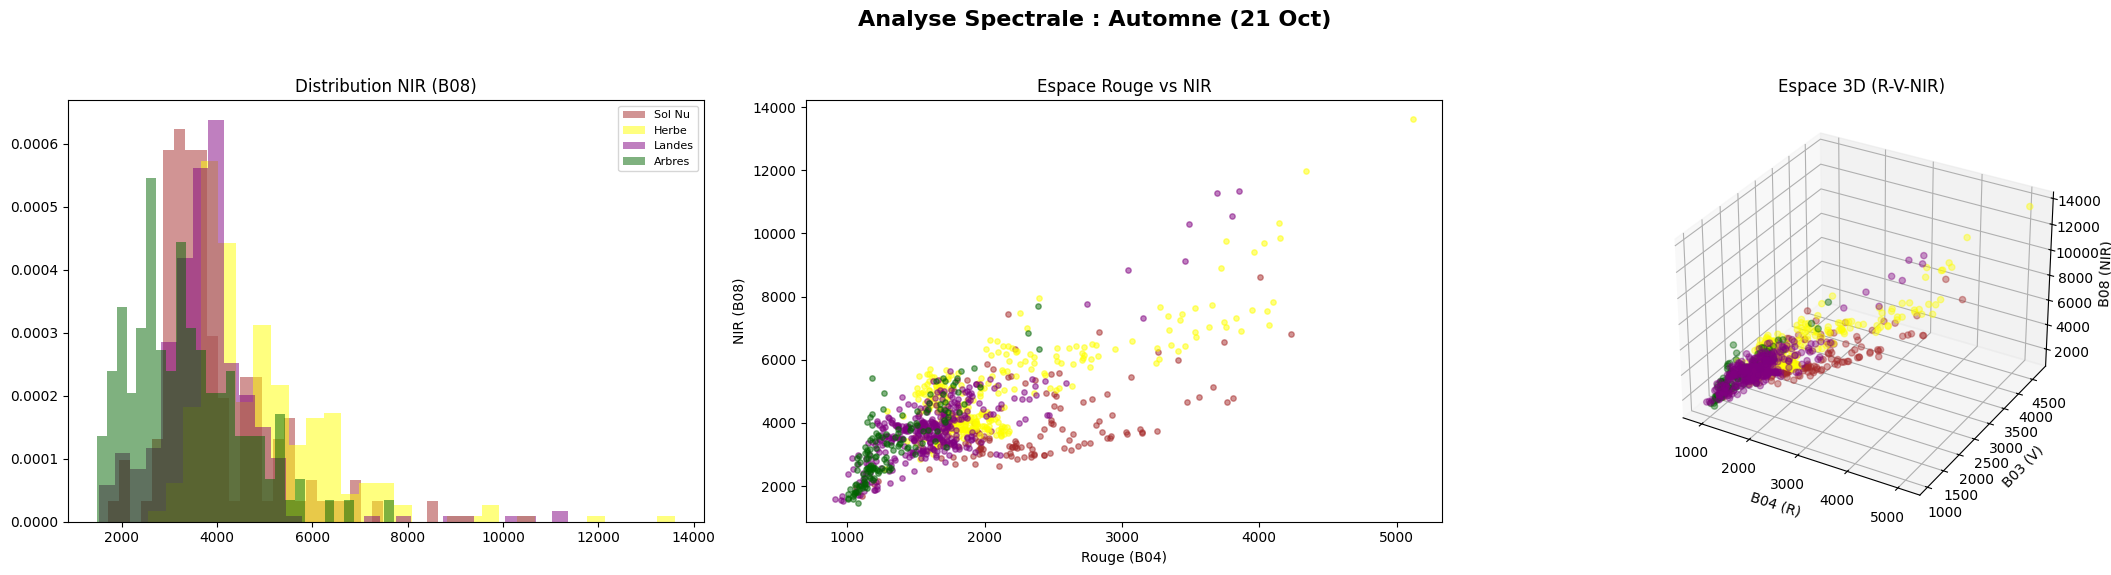

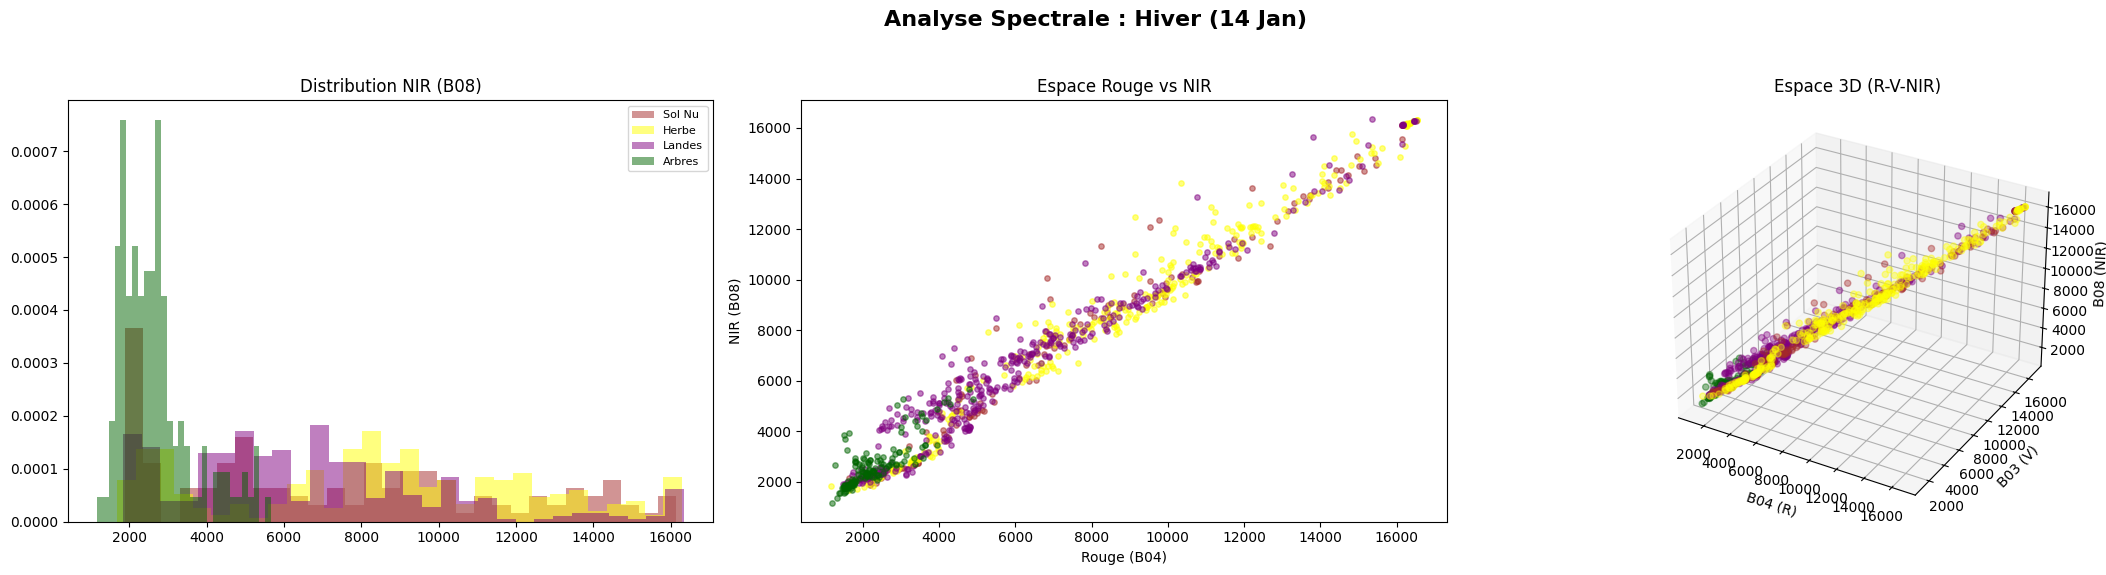

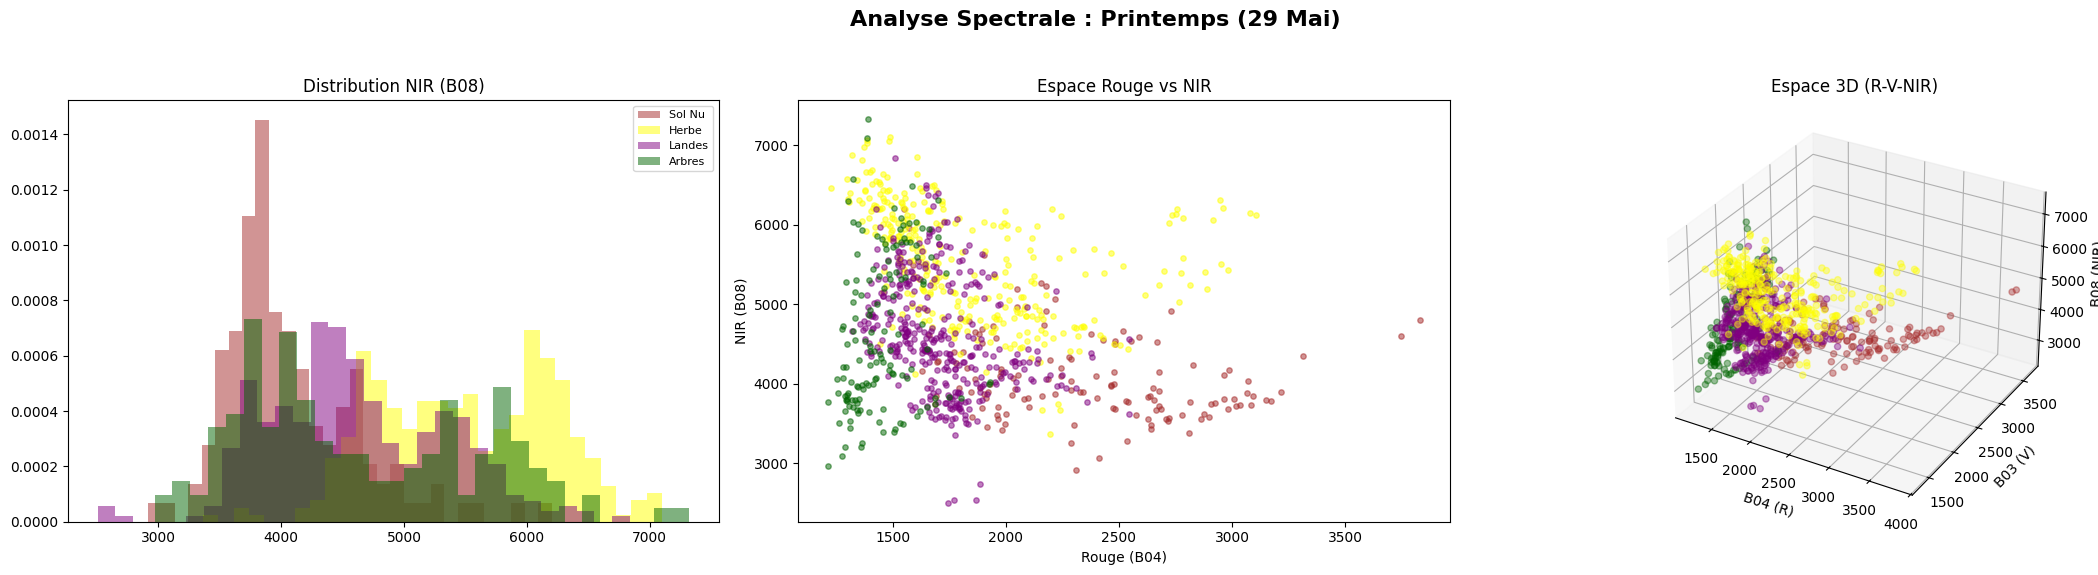

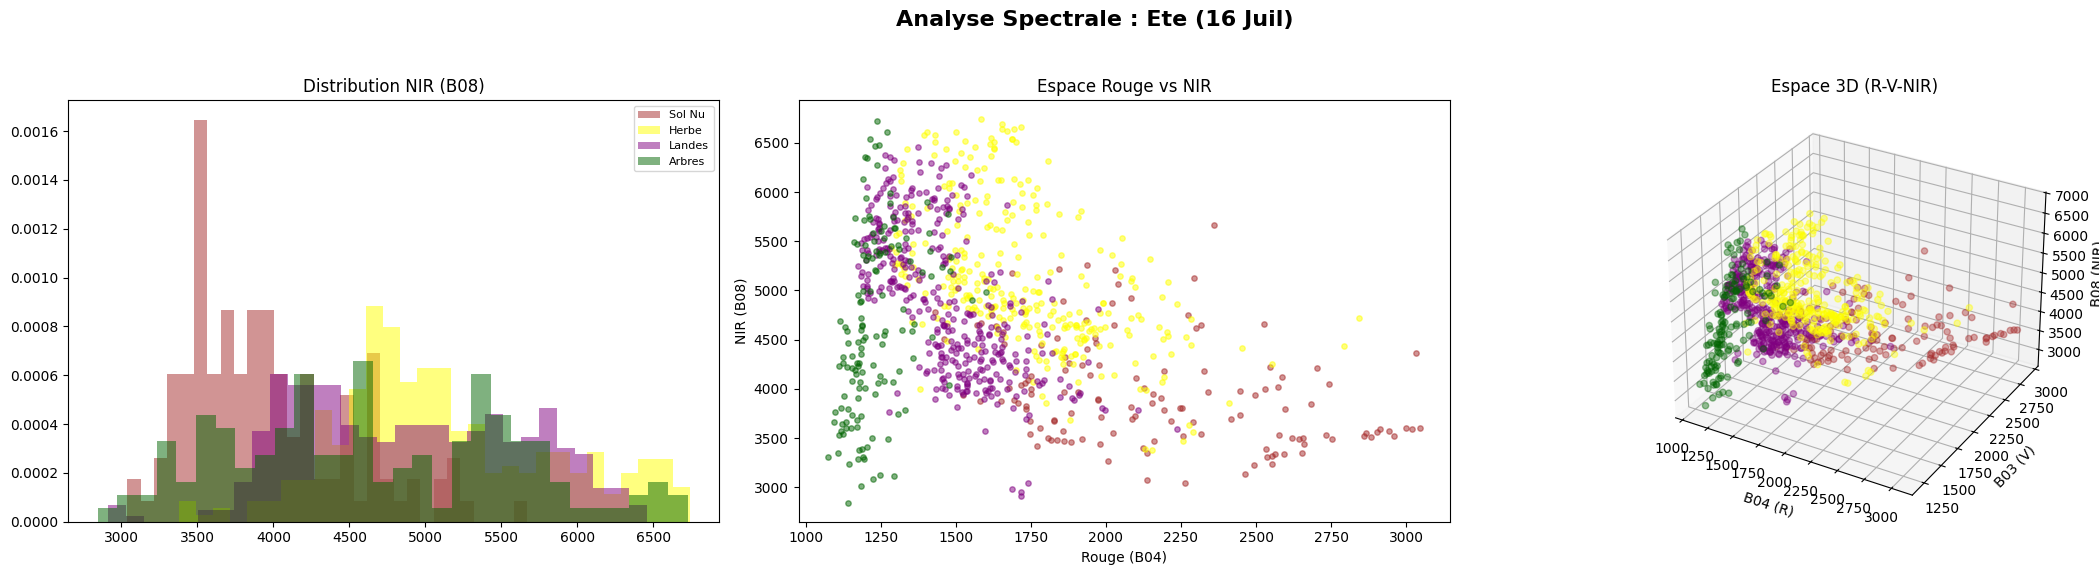

In [30]:
import my_function as mf
import importlib
importlib.reload(mf)

# Définition du dossier
results_fig_dir = 'results/figure'

# Appel de la fonction 
mf.plot_data_analysis(X, Y, results_fig_dir)

## Analyse de la séparabilité spectrale des strates
### 1. Analyse de la distribution NIR (B08) par saison
La distribution des réflectances dans le proche infrarouge (NIR) varie considérablement selon le cycle phénologique :

Hiver : La reflectance est très élevé (jusqu'à 16 000) et on observe une forte dispersion. La présence de neige et la perte des feuilles rend les classes indissociables sur cette bande (mis a part les arbres qui restent reconnaissables)

Été : Les signatures sont plus resserrées avec un maximum autour de 7 000. On observe un fort recouvrement entre les Landes et les Arbres, alors que l'Herbe commence à se détacher vers les hautes valeurs de réflectance. 

Automne : Les contrastes diminuent avec la baisse de l'activité photosynthétique. Les Landes (violet) sont spectralement similaires aux Arbres, confirmant que le NIR seul ne permet pas leur distinction à cette date.

### 2. Espace spectral : Rouge (B04) vs NIR (B08)
Les diagrammes de dispersion 2D illustrent la structure de la végétation et sa séparabilité selon le profil spectral classique :

Printemps : Il s'agit de la période optimale pour la distinction. L'Herbe s'isole nettement en haut à gauche (faible Rouge, fort NIR), tandis que le Sol Nu s'étire vers la droite du graphique (fort Rouge, NIR moyen).

Été : La dispersion est maximale pour le Sol Nu, signe d'une forte hétérogénéité des surfaces minérales. Les classes végétales (notamment 2 et 3) restent groupées, compliquant leur distinction précise. 

Hiver : Les points s'alignent sur une droite de corrélation. Il est difficle d'identifier des seuils clairs pour la classification.

### 3. Analyse de l'espace 3D (Rouge, Vert, NIR)
L'ajout de la bande du Vert (B03) permet d'améliorer la discrimination :

Hiver & Automne : Le nuage de points est très aplati ou linéaire. il est difficile de séparer les 4 classes

Printemps / été : L'espace 3D "déplie" les signatures. Les classes forment des amas plus distincts : l'Herbe est plus reconnaissable, tandis que les Landes et les Arbres se séparent légèrement grâce à l'axe de la bande Verte.

Utilité : Cette visualisation 3D justifie l'utilisation de Random Forest. Il est capable de trouver des frontières de décision complexes dans ce volume où une analyse sur une simple bande échouerait.

# 4.3. Cartographie Finale

In [31]:
import my_function as mf
import importlib
import os
importlib.reload(mf)

# Paramètres
base_dir = '/home/onyxia/work/data/projet_eval'
bandes = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']

# Chemins explicites
nari_path = 'results/ARI_serie_temp.tif'
out_path = 'results/carte_strates.tif'

# Production de la carte
mf.produce_final_map(
    model=best_clf, 
    base=base_dir, 
    bands=bandes, 
    nari_path=nari_path, 
    out=out_path
)

Prediction sur 3009559 pixels valides...


 Carte terminée : results/carte_strates.tif


## Capture d'ecran de la carte obtenu après classification (QGIS)


![Ma Classification](img/Capture_classification.png)


# Conclusion de la Classification et Retour d'Expérience
## 1. Bilan de la cartographie finale
La classification par Random Forest a produit des résultats globalement très satisfaisants pour la zone d'étude des Pyrénées. La carte finale montre une répartition spatiale cohérente des quatre strates végétales :

Fiabilité des extrêmes : Les zones de Sol Nu et de Forêt/Arbres sont bien identifiées, avec une précision atteignant 100 % pour les arbres.

Persistance des confusions : Comme identifié lors de l'analyse spectrale et confirmé par la matrice de confusion, un "bruit" subsiste entre les classes Herbe et Landes. Ces deux végétations basses partagent des signatures proches, ce qui mène à des erreurs lors des tests.

On observe aussi une mauvaise classification des routes : elles sont classées en landes basses au lieu de sol nu. Cela peut être du aux polygones d'entrainements : si aucun polygones n'a été crée sur les routes, alors le modèle ne peut pas les prédire correctement.   

## 2. Optimisation et méthodologie
Le modèle a été optimisé avec différents paramètres : en utilisant 200 arbres de décision avec une profondeur max de 10 et une seule observation par leaf, et en utilisant toutes les variable sans transformation en log. L'analyse des variables les plus discriminantes souligne que le NARI et les bandes du Vert (B03) et du Red Edge (B05) ont été les plus utilisés lors de la classification.


## 3. Note sur l'utilisation de l'assistance IA
Pour ce projet, je me suis basé sur les td vu en cours mais j'ai aussi utilisé l'Intelligence Artificielle pour :

Le déblocage du code : Aide à la structuration des fonctions et résolution des bugs. 

Synhthèse des codes : J'avais des fonctions compliquées et longues, l'IA m'a permis de les rendre plus "propre" et conscises 

La visualisation des données : Optimisation des scripts Matplotlib pour générer les graphiques en 2D et 3D, permettant une meilleure interprétation de la séparabilité des classes.

## 4. Perspectives et Pistes d'amélioration

Bien que les résultats soient satisfaisants, deux axes majeurs pourraient permettre d'affiner encore la précision de la classification :

* **Enrichissement de la base d'apprentissage :**
    L'analyse initiale a révélé un déséquilibre important entre les classes (peu de polygones pour le *Sol Nu* et les *Arbres* par rapport aux *Landes*). Augmenter le nombre de polygones d'entraînement, en ciblant spécifiquement ces classes minoritaires, permettrait au modèle de mieux appréhender leur variabilité spectrale intra-classe et de réduire les biais de prédiction.

* **Intégration du NDVI (Normalized Difference Vegetation Index) et du MNH :**
    Le modèle actuel repose fortement sur le NARI pour détecter les pigments spécifiques (anthocyanes) des landes. L'ajout du NDVI apporterait une information complémentaire sur la **biomasse et la vigueur végétale**.
    La combinaison *NARI* (état physiologique/stress) + *NDVI* (quantité de végétation) permettrait sans doute de mieux discriminer les zones d'Herbe dense des Landes en période de pleine croissance (printemps/été), là où les confusions sont actuellement les plus fortes. 

    L'ajout d'un MNH (Modèle Numérique de Hauteur), comme abordé lors de l'atelier, permettrait peut être de lever les confusions entre l'herbe et les Landes. Le LiDAR permettrait de mesurer la hauteur réelle de la végétation. L'ajout de seuil de hauteur permettrait de compenser les confusions dûes à la signature spectrale similaires de ces 2 classes et ainsi de mieux les discriminer. 



## Diagramme de flux

Le diagramme de flux ci dessous décrit les étapes principales de ce projet.


![Diagramme de flux](img/diagramme_de_flux.png)